# Load Libraries

In [48]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, plot_roc_curve, classification_report, plot_confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from warnings import simplefilter

In [49]:
#To ignore possible unnecessary warnings
simplefilter(action='ignore')
pd.set_option('Display.max_columns', None)

# Load Data

In [50]:
df = pd.read_csv('../../../ml-usecase-classification-humanresourcesattrition/data/HR_cleaned.csv')
df.head()

,Age,Attrition,DailyRate,DistanceFromHome,HourlyRate,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,StandardHours,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Female,Gender_Male,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,41,1,1102,1,94,5993,19479,8,11,80,8,0,1,6,4,0,5,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1
1,49,0,279,8,61,5130,24907,1,23,80,10,3,3,10,7,1,7,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0
2,37,1,1373,2,92,2090,2396,6,15,80,7,3,3,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1
3,33,0,1392,3,56,2909,23159,1,11,80,8,3,3,8,7,3,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1
4,27,0,591,2,40,3468,16632,9,12,80,6,3,3,2,2,2,2,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0


# Split into train and test
First of all, split into features and label

In [51]:
X = df.drop(columns=['Attrition'])
y = df['Attrition']

For this purpose you can use `train_test_split()` or `StratifiedShuffleSplit()`. The main advantage of `StratifiedShuffleSplit()` is your train and test sets will have the same ratio of negative and positive cases. We will use and compare both. We will choose 70% of the dataset for the training set and the remaining 30% of the dataset for the testing set.
___
- `train_test_split()`: On this dataset, using this method, the training set will have a greater proportion of positive cases than the testing set.

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

In [53]:
y_train.value_counts()/len(y_train)

0    0.822024
1    0.177976
Name: Attrition, dtype: float64

In [54]:
y_test.value_counts()/len(y_test)

0    0.831606
1    0.168394
Name: Attrition, dtype: float64

___
- `StratifiedShuffleSplit()`: Both training set and testing set have the same proportion of positive cases.

In [55]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state= 2)
for train_index, test_index in split.split(df, df['Attrition']):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [56]:
strat_train_set['Attrition'].value_counts()/len(strat_train_set)

0    0.825362
1    0.174638
Name: Attrition, dtype: float64

In [57]:
strat_test_set['Attrition'].value_counts()/len(strat_test_set)

0    0.823834
1    0.176166
Name: Attrition, dtype: float64

In [58]:
X_train = strat_train_set.drop(columns=['Attrition'])
X_test = strat_test_set.drop(columns = ['Attrition'])
y_train = strat_train_set['Attrition']
y_test = strat_test_set['Attrition']

# Scale the Data
You might need to scale your features to avoid some bias. You have many choices of scalers. In that case, the scaler used is `MinMaxScaler()` from *Scikit-Learn*. You can check all available scalers on *Scikit Learn* on [this link](https://scikit-learn.org/stable/modules/classes.html?highlight=preprocessing#module-sklearn.preprocessing). Search for `MinMaxScaler()`, `StandardScaler()` or `Robust Scaler` and try to understand which of them you should use in each case. If you want to have a visual demonstration of each scale to choose each one you think is the most suitable, please check [this link](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html).

In [59]:
numeric_features = ['Age', 'DailyRate','DistanceFromHome','HourlyRate','MonthlyIncome','MonthlyRate','NumCompaniesWorked',
                    'PercentSalaryHike','TotalWorkingYears','YearsAtCompany','YearsInCurrentRole','YearsSinceLastPromotion',
                    'YearsWithCurrManager','WorkLifeBalance','TrainingTimesLastYear']

minmax = MinMaxScaler()
X_train_scaled = pd.DataFrame(minmax.fit_transform(X_train[numeric_features]))
X_test_scaled = pd.DataFrame(minmax.fit_transform(X_test[numeric_features]))

X_train_scaled.columns = X_train[numeric_features].columns
X_test_scaled.columns = X_test[numeric_features].columns

X_train_scaled = pd.concat([X_train_scaled.reset_index(), X_train.drop(columns=numeric_features).reset_index()], axis=1).drop(columns = ['index'])
X_test_scaled = pd.concat([X_test_scaled.reset_index(), X_test.drop(columns=numeric_features).reset_index()], axis=1).drop(columns = ['index'])

In [60]:
X_train_scaled.head()

,Age,DailyRate,DistanceFromHome,HourlyRate,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,WorkLifeBalance,TrainingTimesLastYear,StandardHours,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Female,Gender_Male,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,0.880952,0.740688,0.000000,0.728571,0.928610,0.414304,0.222222,0.142857,0.837838,0.411765,0.466667,0.000000,0.000000,1.000000,0.666667,80,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0
1,0.428571,0.894699,0.285714,0.514286,0.121870,0.286764,0.111111,0.785714,0.135135,0.294118,0.266667,0.000000,0.133333,0.666667,0.500000,80,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0
2,0.309524,0.426218,0.321429,0.142857,0.678170,0.994498,0.444444,0.642857,0.351351,0.647059,0.466667,0.266667,0.533333,1.000000,0.333333,80,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0
3,0.333333,0.626074,0.892857,1.000000,0.233861,0.400450,0.000000,0.500000,0.108108,0.176471,0.133333,0.133333,0.133333,0.666667,0.333333,80,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0
4,0.357143,0.924069,0.071429,0.371429,0.128569,0.845796,0.111111,0.000000,0.216216,0.470588,0.466667,0.200000,0.000000,0.666667,0.500000,80,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1


As you could see at EDA(*Exploratory Data Analysis*) stage, *Attrition* column, the label column, is imbalanced and this is a problem to classification model. To solve this, you can use a technique called SMOTE(Synthetic Minority Oversampling Technique). You can reade more about SMOTE on [this link](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/). Note that you can only use SMOTE on **training set**.

In [61]:
y.value_counts()

0    1060
1     225
Name: Attrition, dtype: int64

In [62]:
oversample = SMOTE()
X_train_sampled, y_train_sampled = oversample.fit_resample(X_train_scaled, y_train)

There are some models that have an argument which balances the data automatically. If you are using `LogisticRegression()`from *Scikit-Learn*, the argument is called *class_weights* and you just have to set it as *'balanced'*. Check the documentation of `LogisticRegression()` on [this link](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) to understand this argument. Depending on the model you are using, the name of the argument can change. However, the effect is the same. Check the documentation of each model to see how the argument is called and how you can use it to balance your data. If you use these arguments in your model to balance your data, you don't need to use SMOTE.

# Modeling

To do the modeling, we are choosing LogisticRegression. We should try another models and see which model performs better. We will use a function called `GridSearchCV()`: This function allows to optimize the model hyperparameters using cross validation, which means you have to choose how many folds you want to use in your validation. We recomend to use 5 folds or 10. To know what are the parameters to optimize you should consult the documentation of the model you are using. Furthermore, you should look into what are the best parameters to optimize, saving computation time. The more parameters, the longer it takes to run. This function will define the best model, according to the metrics you choose. Usually, for classification problems, the metric that is used is *roc_auc*.

- **Logistic Regression**

In [63]:
lr = LogisticRegression()

#Define a set of hyperparameters to optimize and their values
parameters = {'penalty':['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}
lr_model = GridSearchCV(estimator=lr,param_grid=parameters, cv=5, scoring='roc_auc', refit=True)

#Train the model
lr_model.fit(X_train_sampled, y_train_sampled)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']},
             scoring='roc_auc')

You can see the best estimator hyperparameters

In [64]:
lr_model.best_estimator_

LogisticRegression(C=10)

You can see the results of each set of parameters

In [65]:
pd.DataFrame(lr_model.cv_results_).sort_values(by='rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,0.020523,0.001985,0.003022,0.000839,10,l2,"{'C': 10, 'penalty': 'l2'}",0.786233,0.981453,0.995057,0.990024,0.980278,0.946609,0.080375,1
7,0.022224,0.001638,0.002715,0.000396,1,l2,"{'C': 1, 'penalty': 'l2'}",0.812806,0.974968,0.984899,0.974742,0.978588,0.945201,0.066299,2
11,0.021517,0.001730,0.002584,0.000768,100,l2,"{'C': 100, 'penalty': 'l2'}",0.768411,0.981680,0.996100,0.989933,0.982469,0.943719,0.087812,3
13,0.021784,0.002135,0.002505,0.000447,1000,l2,"{'C': 1000, 'penalty': 'l2'}",0.752948,0.983902,0.994377,0.988300,0.982925,0.940490,0.093859,4
5,0.021548,0.003396,0.002900,0.001227,0.1,l2,"{'C': 0.1, 'penalty': 'l2'}",0.821195,0.925313,0.933884,0.920824,0.940467,0.908337,0.044097,5
3,0.010218,0.001735,0.002000,0.000632,0.01,l2,"{'C': 0.01, 'penalty': 'l2'}",0.803918,0.843416,0.856929,0.848948,0.875228,0.845688,0.023493,6
1,0.005657,0.000873,0.002839,0.000836,0.001,l2,"{'C': 0.001, 'penalty': 'l2'}",0.791357,0.814257,0.829267,0.817613,0.846877,0.819874,0.018261,7
0,0.000631,0.000801,0.000000,0.000000,0.001,l1,"{'C': 0.001, 'penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
2,0.000460,0.000407,0.000000,0.000000,0.01,l1,"{'C': 0.01, 'penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
4,0.000400,0.000490,0.000000,0.000000,0.1,l1,"{'C': 0.1, 'penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,10


# Model Evaluation

To evaluate the model you should use the test set. You can use `lr_model`object to predict because `GridSearchCV()` function has an argument called *refit*. When this argument is set as **True**, `lr_model` is refitted with the best set of hyperparameters.

- **Predictions**

In [66]:
y_preds= lr_model.predict(X_test_scaled)
y_preds_proba = lr_model.predict_proba(X_test_scaled)
preds = pd.concat([pd.Series(y_preds), pd.DataFrame(y_preds_proba)], axis=1)
preds.columns = ['y_preds','y_pred_proba_0','y_pred_proba_1']
preds.head(10)

,y_preds,y_pred_proba_0,y_pred_proba_1
0,1,0.411303,0.588697
1,0,0.742474,0.257526
2,1,0.343432,0.656568
3,0,0.924610,0.075390
4,0,0.973438,0.026562
5,1,0.361291,0.638709
6,0,0.660513,0.339487
7,0,0.902569,0.097431
8,0,0.913736,0.086264
9,0,0.937987,0.062013


___
- **Metrics**

In [67]:
precision, recall, threshold = precision_recall_curve(y_test, y_preds_proba[:,1])
df_metrics = pd.concat([pd.DataFrame(precision), pd.DataFrame(recall), pd.DataFrame(threshold)], axis=1)
df_metrics.columns = ['Precision','Recall','Threshold']
df_metrics['f1'] = 2* ((df_metrics.Precision * df_metrics.Recall)/(df_metrics.Precision + df_metrics.Recall))
df_metrics

,Precision,Recall,Threshold,f1
0,0.176166,1.000000,0.000218,0.299559
1,0.176623,1.000000,0.000219,0.300221
2,0.177083,1.000000,0.000347,0.300885
3,0.177546,1.000000,0.000697,0.301552
4,0.178010,1.000000,0.000917,0.302222
...,...,...,...,...
382,1.000000,0.058824,0.874789,0.111111
383,1.000000,0.044118,0.877468,0.084507
384,1.000000,0.029412,0.915050,0.057143
385,1.000000,0.014706,0.941284,0.028986


You can plot the roc curve and check the AUC value for test.

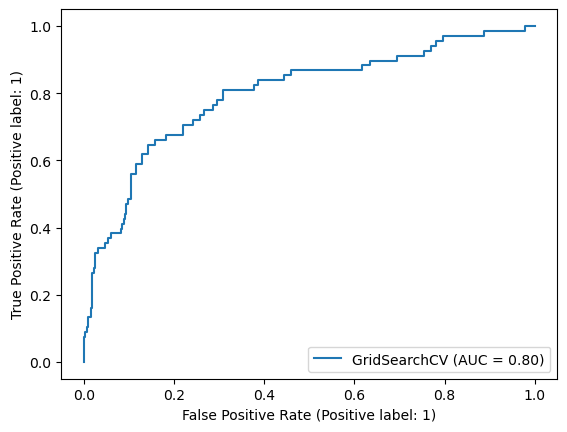

In [68]:
plot_roc_curve(lr_model, X_test_scaled, y_test)

You can compare the results with training test. If the values are too diferent (like 0.78 for test and 0.96 for train) it means that the model is overfitting and we have to solve that. One way is to do a better optimization of the hyperparameters. Another way is to implement another models.

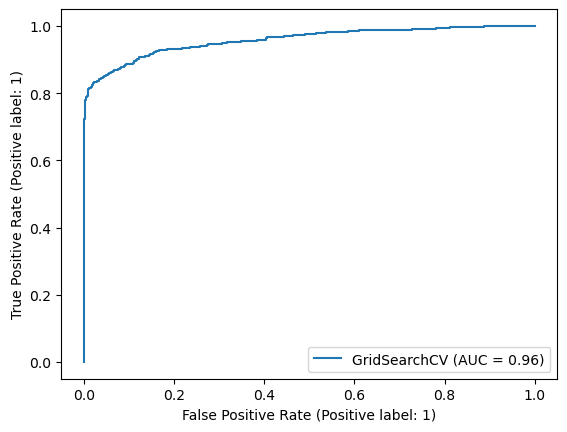

In [69]:
plot_roc_curve(lr_model, X_train_sampled, y_train_sampled)

You can check the classification report provided by Scikit Learn.

In [70]:
print(classification_report(y_test, preds['y_preds']))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91       318
           1       0.62      0.34      0.44        68

    accuracy                           0.85       386
   macro avg       0.75      0.65      0.67       386
weighted avg       0.83      0.85      0.83       386



You can check the confusion matrix to see what your model is failing the most in.

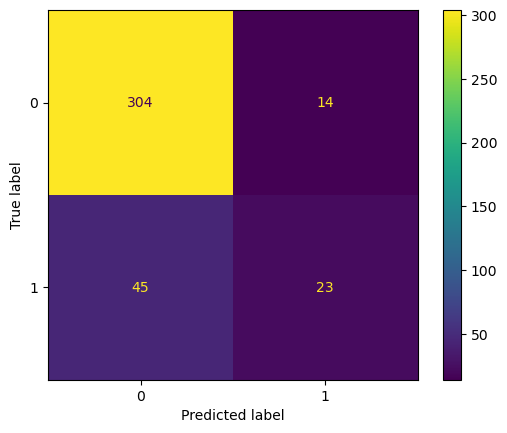

In [71]:
plot_confusion_matrix(lr_model, X_test_scaled, y_test)

The results from the previous classification report aren't optimized according to the treshold. What we can do is check the maximum *f1* value on *df_metrics* and get the correspondent threshold. Then, we take the previous computed probabilities and if the probability of class 1 is higher or equal to the threshold, we assign class 1.  Otherwise, we assign class 0. Let's do it and check the results.

In [72]:
maxf1 = df_metrics.f1.max()

maxf1threshold = df_metrics[df_metrics.f1 == maxf1]['Threshold']

preds.loc[preds['y_pred_proba_1']>= float(maxf1threshold), 'y_preds_t'] = 1
preds.loc[preds['y_pred_proba_1']< float(maxf1threshold), 'y_preds_t'] = 0

In [73]:
print(classification_report(y_test, preds['y_preds_t']))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89       318
           1       0.49      0.65      0.56        68

    accuracy                           0.82       386
   macro avg       0.71      0.75      0.72       386
weighted avg       0.84      0.82      0.83       386



The results aren't better which means that the model needs to be improved. Test another models, try another combinations of hyperparameters or another aproaches.

## After developing your model you wan't to save it. Lets do it using joblib.

In [74]:
import joblib

The next cell will create a file for your model and save it in the local working directory.

In [75]:
filename = './HR_model_load.sav'
joblib.dump(lr_model, filename)

['./HR_model_load.sav']

Now you can load the model whenever you want in other files. Let's confirm creating a new variable and comparing results.

In [76]:
lr_model_copy = joblib.load('HR_model_load.sav')
y_preds_copy = lr_model_copy.predict(X_test_scaled)
(y_preds == y_preds_copy)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,